In [1]:
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import sys
import os

# Add project root to path - adjust the number of parent dirs (..) based on where your notebook is located
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import utils

importlib.reload(utils)
from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"

from src.datahandlers import PacmanDataReader

In [2]:
## TODO include this psych preproc in the DataReader class
data = PacmanDataReader(data_folder="../../data/", read_games_only=False)

user_df = data.user_df
game_df = data.game_df
gamestate_df = data.gamestate_df
psychometrics_df = data.psychometrics_df

In [3]:
whole_games = game_df.loc[(game_df["win"] == 0)]

# extract game features from gamestate df
# TODO get the game length as the sum of the times of previous game_ids.
whole_games_scores = (
    gamestate_df.loc[gamestate_df["game_id"].isin(whole_games["game_id"])]
    .groupby("game_id")
    .agg({"score": "max"})
)

whole_games = pd.merge(whole_games, whole_games_scores, how="outer", on="game_id")

whole_games["total_whole_games_played"] = whole_games.groupby("user_id").cumcount() + 1

In [4]:
flow_items = ["fss_1", "fss_2", "fss_3", "fss_4", "fss_5", "fss_6", "fss_7", "fss_8"]

flow = psychometrics_df.loc[psychometrics_df["redcap_repeat_instrument"] == "flow"].loc[
    :, ["record_id", "total_games_flow", "redcap_repeat_instance"] + flow_items
]


flow = flow.rename(
    columns={"record_id": "user_id", "total_games_flow": "total_games_played"}
)

flow["FLOW"] = flow.iloc[:, 3:].sum(axis=1)

In [5]:
perf_psych_df = (
    pd.merge(
        flow,
        whole_games[
            [
                "user_id",
                "total_games_played",
                "total_whole_games_played",
                "game_id",
                "score",
            ]
        ],
        on=["user_id", "total_games_played"],
        how="right",
    )
    .dropna()
    .drop(columns=flow_items + ["total_games_played", "redcap_repeat_instance"])
)

perf_psych_df["log(score)"] = np.log(perf_psych_df["score"])
perf_psych_df["inv(score)"] = (
    perf_psych_df["score"].max() - perf_psych_df["score"] + 1
)  # Avoid zeros
perf_psych_df["log(inv(score))"] = np.log(perf_psych_df["inv(score)"])

perf_psych_df["log(total_whole_games_played)"] = np.log(
    perf_psych_df["total_whole_games_played"]
)  ## i.e., cum trials

perf_psych_df["flow_z_score"] = perf_psych_df.groupby("user_id")["FLOW"].transform(
    lambda x: (x - x.mean()) / x.std()
)

perf_psych_df["cum_score"] = perf_psych_df.groupby("user_id")["score"].cumsum()
perf_psych_df["log(cum_score)"] = np.log(perf_psych_df["cum_score"])

# Calculate deviation from linear regression for each participant
from sklearn.linear_model import LinearRegression

# Initialize lists to store results
user_ids = []
deviations = []

# Group by user_id and calculate deviation for each user
for user_id, user_data in perf_psych_df.groupby("user_id"):
    # Prepare data
    X = user_data[["total_whole_games_played"]]
    y = user_data["log(inv(score))"]

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Calculate predicted values
    y_pred = model.predict(X)

    # Calculate deviation (real - predicted)
    deviation = y - y_pred

    # Store results
    user_ids.extend([user_id] * len(deviation))
    deviations.extend(deviation)

# Add deviation column to dataframe
perf_psych_df["score_deviation"] = deviations

In [6]:
# Get users with more than 8 total whole games
users_with_many_games = (
    perf_psych_df.groupby("user_id")["total_whole_games_played"].max() > 9
)
users_to_keep = users_with_many_games[users_with_many_games].index
perf_psych_df = perf_psych_df[perf_psych_df["user_id"].isin(users_to_keep)]

# Count unique users after filtering
print(perf_psych_df.loc[:, "user_id"].unique().__len__())

perf_psych_df
# # Create new dataframe with average scores per game number
# avg_scores_df = perf_psych_df.groupby('total_whole_games_played')['score'].mean().reset_index()
# avg_scores_df.columns = ['game_number', 'avg_score']
# avg_scores_df = avg_scores_df.loc[avg_scores_df["game_number"] <= 10]
# avg_scores_df

11


,user_id,FLOW,total_whole_games_played,game_id,score,log(score),inv(score),log(inv(score)),log(total_whole_games_played),flow_z_score,cum_score,log(cum_score),score_deviation
5,69,32.0,2,399,2650,7.882315,15471,9.646723,0.693147,-0.783373,2650,7.882315,-0.138191
6,69,24.0,3,400,2750,7.919356,15371,9.640238,1.098612,-1.515877,5400,8.594154,0.118792
7,69,36.0,4,401,3000,8.006368,15121,9.623840,1.386294,-0.417121,8400,9.035987,0.000000
8,69,30.0,5,402,2240,7.714231,15881,9.672879,1.609438,-0.966499,10640,9.272376,0.000000
9,69,56.0,6,404,7470,8.918650,10651,9.273409,1.791759,1.414140,18110,9.804220,0.016037
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,163,17.0,29,1264,2990,8.003029,15131,9.624501,3.367296,-2.553783,107970,11.589609,-0.044570
503,163,28.0,30,1265,4080,8.313852,14041,9.549737,3.401197,-1.153719,112050,11.626700,0.000000
504,163,39.0,31,1267,8750,9.076809,9371,9.145375,3.433987,0.246346,120800,11.701892,0.000000
505,163,34.0,32,1269,4210,8.345218,13911,9.540435,3.465736,-0.390047,125010,11.736149,0.000000


In [7]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,6))

# plt.scatter(x=avg_scores_df["game_number"], y=avg_scores_df["avg_score"])

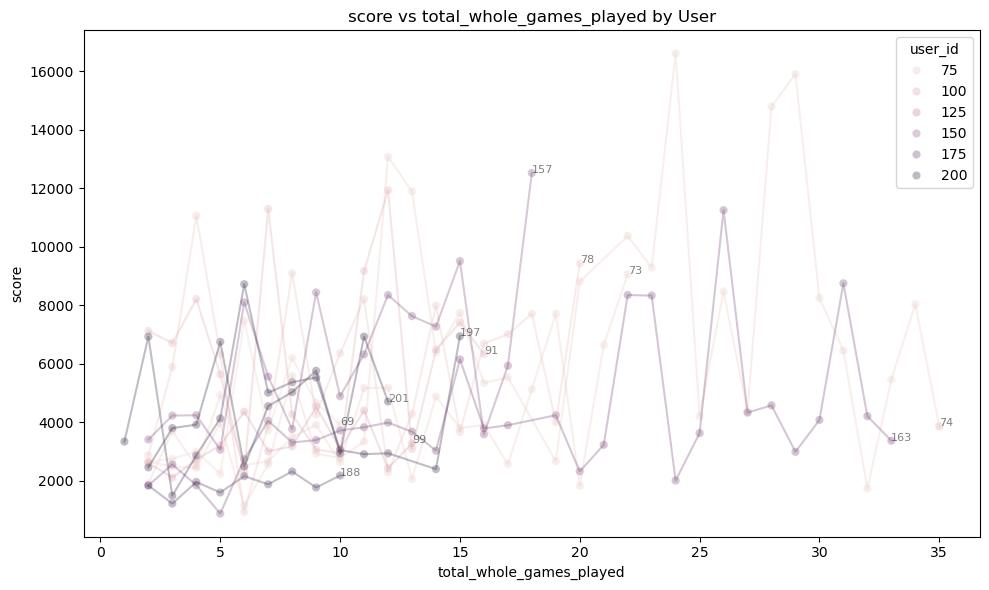

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

x = "total_whole_games_played"
y = "score"

plt.figure(figsize=(10, 6))

sns.scatterplot(data=perf_psych_df, x=x, y=y, hue="user_id", alpha=0.31)

# Add user_id labels to each point
for user_id in perf_psych_df["user_id"].unique():
    user_data = perf_psych_df[perf_psych_df["user_id"] == user_id]
    last_row = user_data.iloc[-1]  # Get the last row for each user
    plt.annotate(
        str(int(user_id)),
        (last_row[x], last_row[y]),  # Fixed x,y order to match scatterplot
        fontsize=8,
        alpha=0.5,
    )

sns.lineplot(data=perf_psych_df, x=x, y=y, hue="user_id", alpha=0.3, legend=False)

plt.title(f"{y} vs {x} by User")
plt.xlabel(f"{x}")
plt.ylabel(f"{y}")


plt.tight_layout()
plt.show()

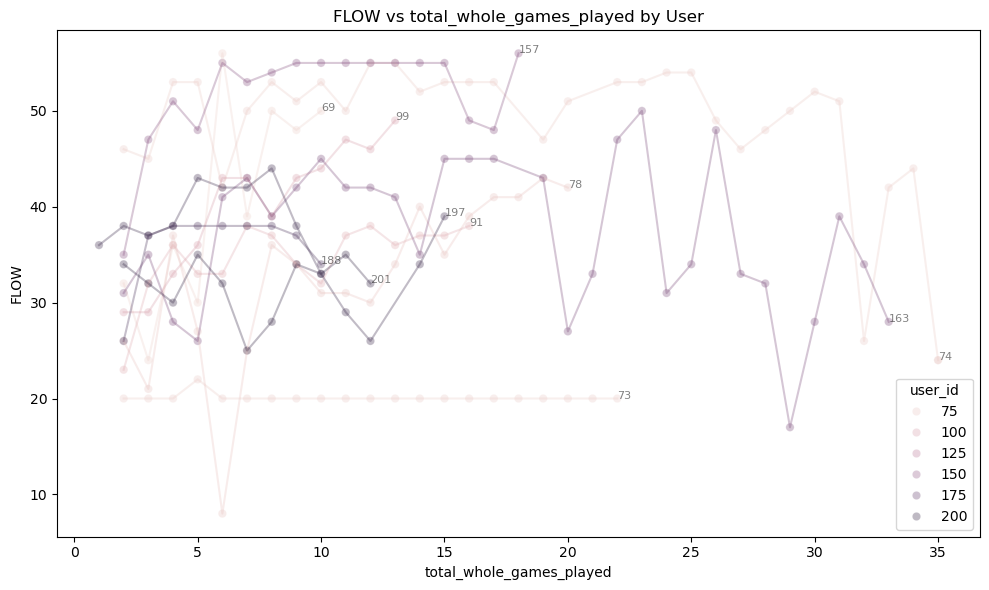

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

x = "total_whole_games_played"
y = "FLOW"

plt.figure(figsize=(10, 6))

sns.scatterplot(data=perf_psych_df, x=x, y=y, hue="user_id", alpha=0.31)

# Add user_id labels to each point
for user_id in perf_psych_df["user_id"].unique():
    user_data = perf_psych_df[perf_psych_df["user_id"] == user_id]
    last_row = user_data.iloc[-1]  # Get the last row for each user
    plt.annotate(
        str(int(user_id)),
        (last_row[x], last_row[y]),  # Fixed x,y order to match scatterplot
        fontsize=8,
        alpha=0.5,
    )

sns.lineplot(data=perf_psych_df, x=x, y=y, hue="user_id", alpha=0.3, legend=False)

plt.title(f"{y} vs {x} by User")
plt.xlabel(f"{x}")
plt.ylabel(f"{y}")


plt.tight_layout()
plt.show()

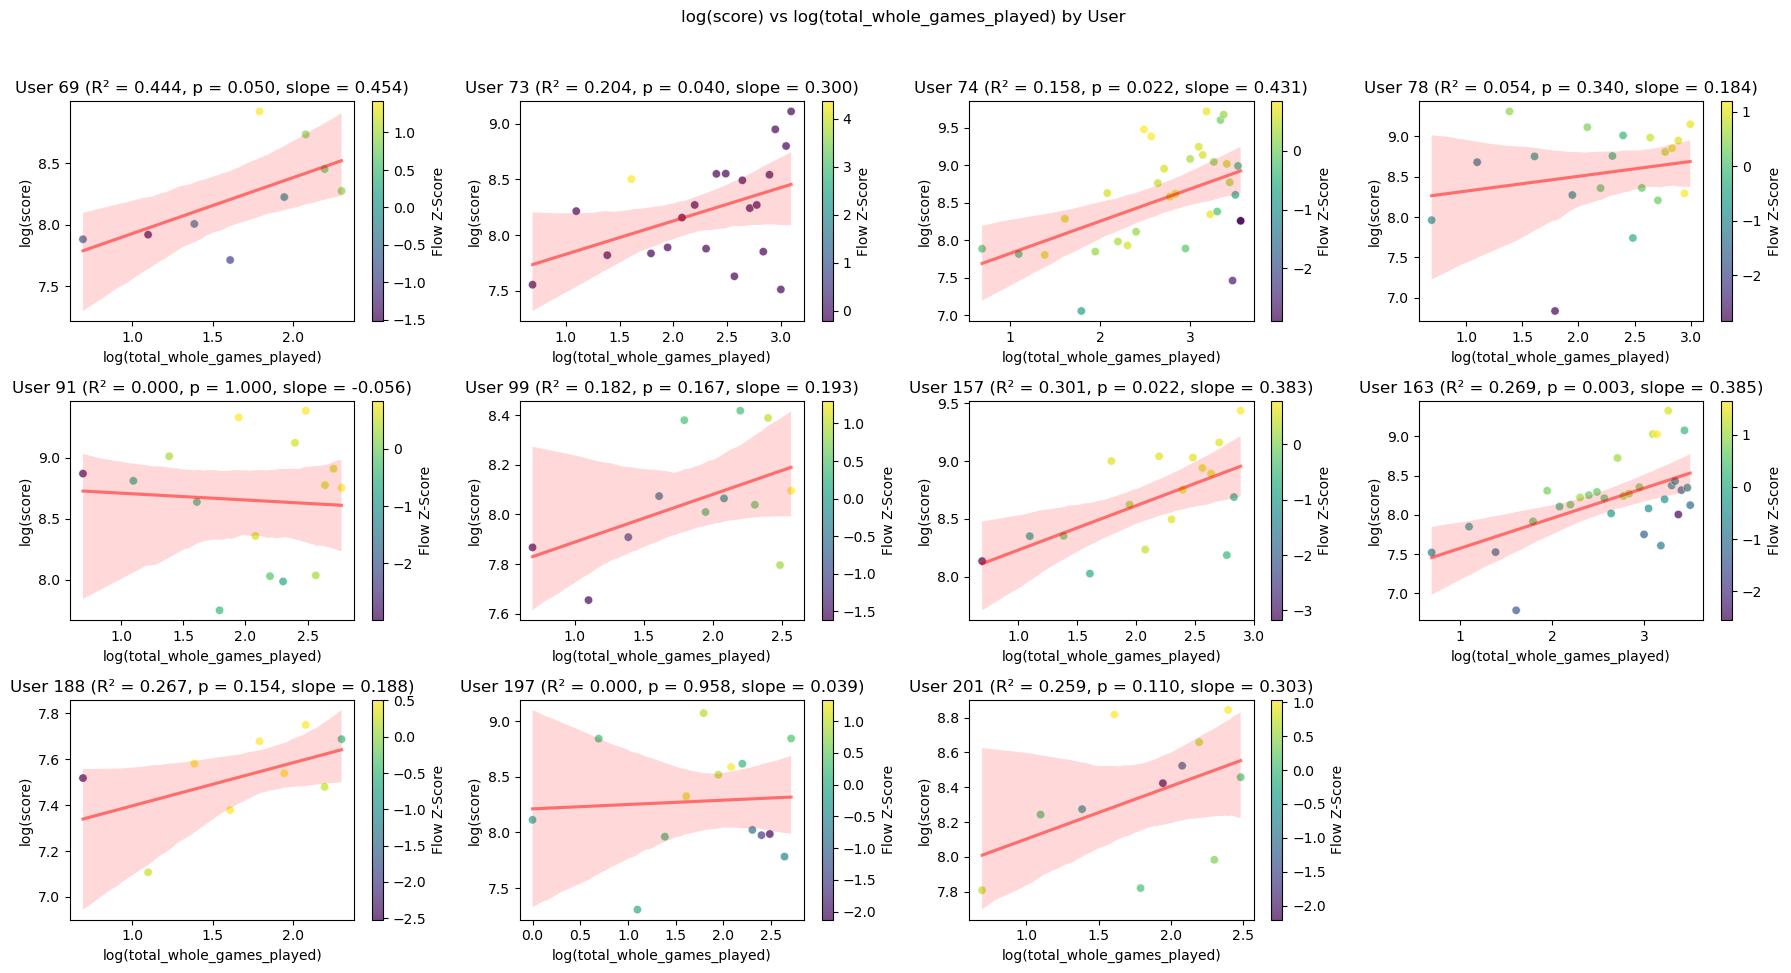

In [10]:
from scipy import stats

# Calculate number of subplots needed
n_users = len(perf_psych_df["user_id"].unique())
m = int(np.ceil(np.sqrt(n_users)))

# Variable names (columns)
x = "log(total_whole_games_played)"
y = "log(score)"

# Create subplots
fig, axes = plt.subplots(m, m, figsize=(18, 12))
fig.suptitle(f"{y} vs {x} by User", y=1.02)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot for each user
for i, user_id in enumerate(perf_psych_df["user_id"].unique()):
    user_data = perf_psych_df[perf_psych_df["user_id"] == user_id]

    # Calculate Spearman correlation and R^2
    corr, p_value = stats.spearmanr(user_data[x], user_data[y])
    r_squared = corr**2

    # Fit linear regression
    slope, intercept, r_value, p_value_reg, std_err = stats.linregress(
        user_data[x], user_data[y]
    )

    scatter = sns.scatterplot(
        data=user_data,
        x=x,
        y=y,
        c=user_data["flow_z_score"],
        cmap="viridis",
        ax=axes[i],
        alpha=0.7,
    )

    # Add colorbar for each subplot
    plt.colorbar(scatter.collections[0], ax=axes[i], label="Flow Z-Score")

    sns.regplot(
        data=user_data,
        x=x,
        y=y,
        ax=axes[i],
        scatter=False,
        color="red",
        line_kws={"alpha": 0.5},
    )

    # Add R^2 value and slope to plot title
    axes[i].set_title(
        f"User {user_id} (R² = {r_squared:.3f}, p = {p_value:.3f}, slope = {slope:.3f})"
    )
    axes[i].set_xlabel(f"{x}")
    axes[i].set_ylabel(f"{y}")

# Hide empty subplots
for i in range(n_users, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

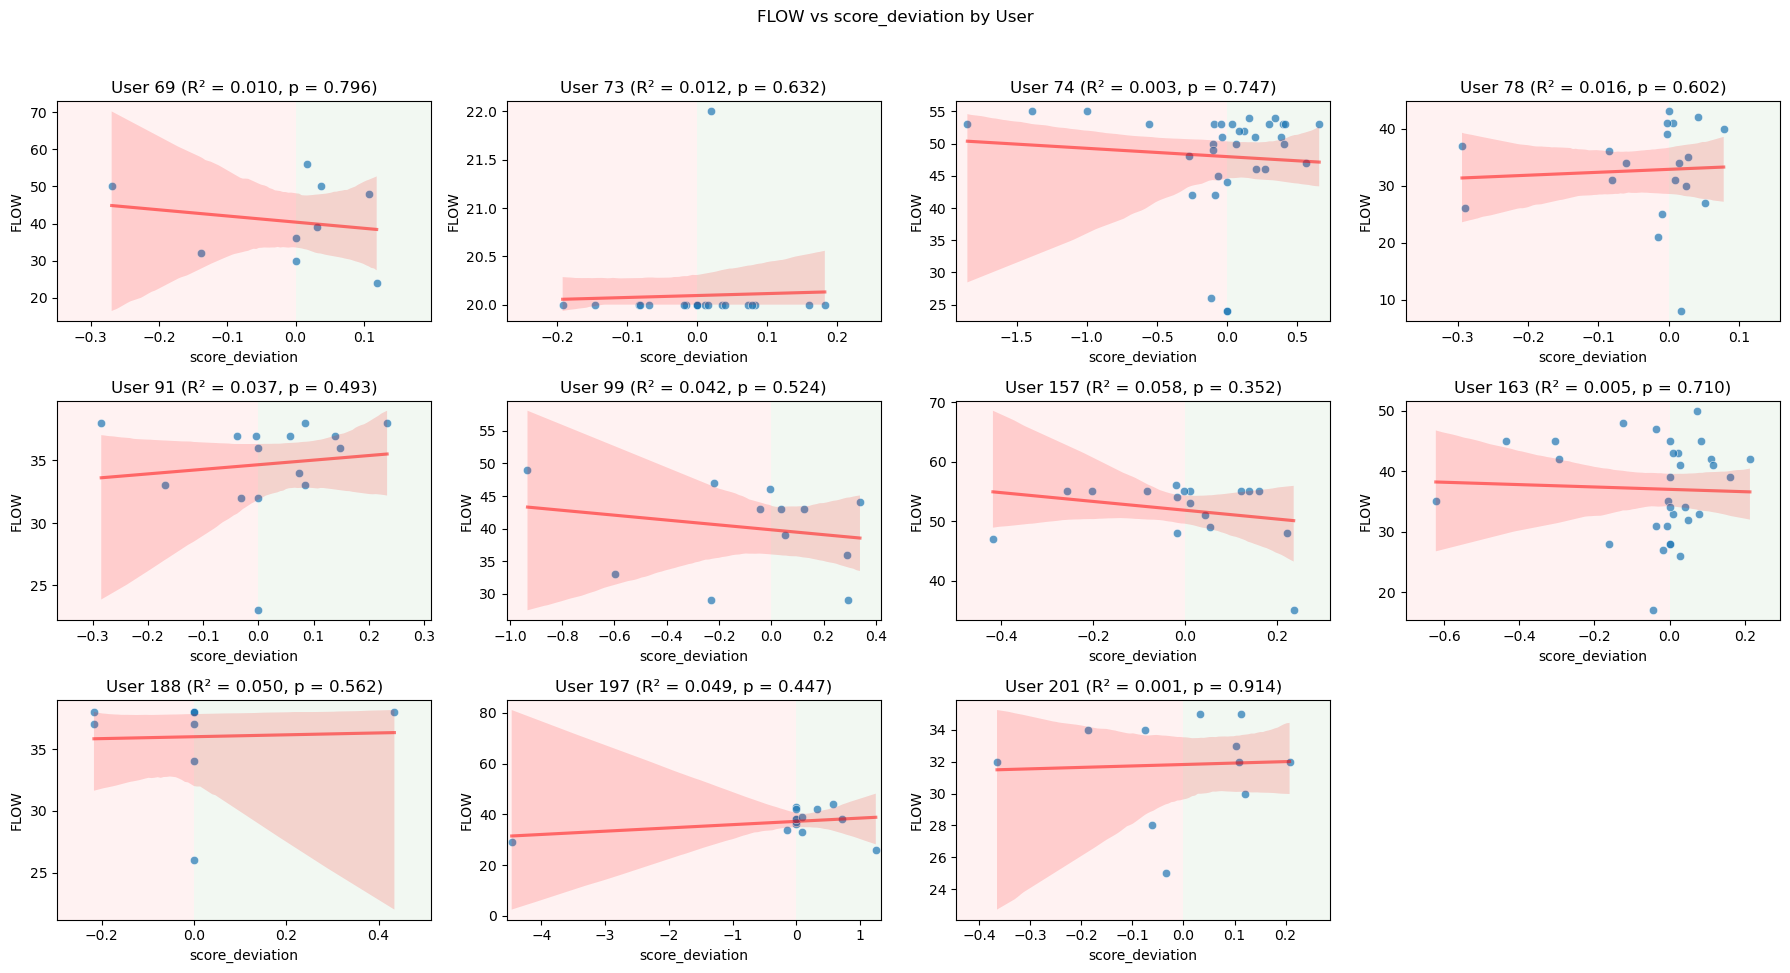

In [11]:
from scipy import stats

# Calculate number of subplots needed
n_users = len(perf_psych_df["user_id"].unique())
m = int(np.ceil(np.sqrt(n_users)))

# Variable names (columns)
x = "score_deviation"
y = "FLOW"

# Create subplots
fig, axes = plt.subplots(m, m, figsize=(18, 12))
fig.suptitle(f"{y} vs {x} by User", y=1.02)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot for each user
for i, user_id in enumerate(perf_psych_df["user_id"].unique()):
    user_data = perf_psych_df[perf_psych_df["user_id"] == user_id]

    # Calculate Spearman correlation and R^2
    corr, p_value = stats.spearmanr(user_data[x], user_data[y])
    r_squared = corr**2

    # Add colored background
    axes[i].set_xlim(left=user_data[x].min() - 0.08, right=user_data[x].max() + 0.08)
    axes[i].axvspan(xmin=axes[i].get_xlim()[0], xmax=0, facecolor="red", alpha=0.05)
    axes[i].axvspan(xmin=0, xmax=axes[i].get_xlim()[1], facecolor="green", alpha=0.05)

    scatter = sns.scatterplot(data=user_data, x=x, y=y, ax=axes[i], alpha=0.7)

    sns.regplot(
        data=user_data,
        x=x,
        y=y,
        ax=axes[i],
        scatter=False,
        color="red",
        line_kws={"alpha": 0.5},
    )

    # Add R^2 value to plot title
    axes[i].set_title(f"User {user_id} (R² = {r_squared:.3f}, p = {p_value:.3f})")
    axes[i].set_xlabel(f"{x}")
    axes[i].set_ylabel(f"{y}")

# Hide empty subplots
for i in range(n_users, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

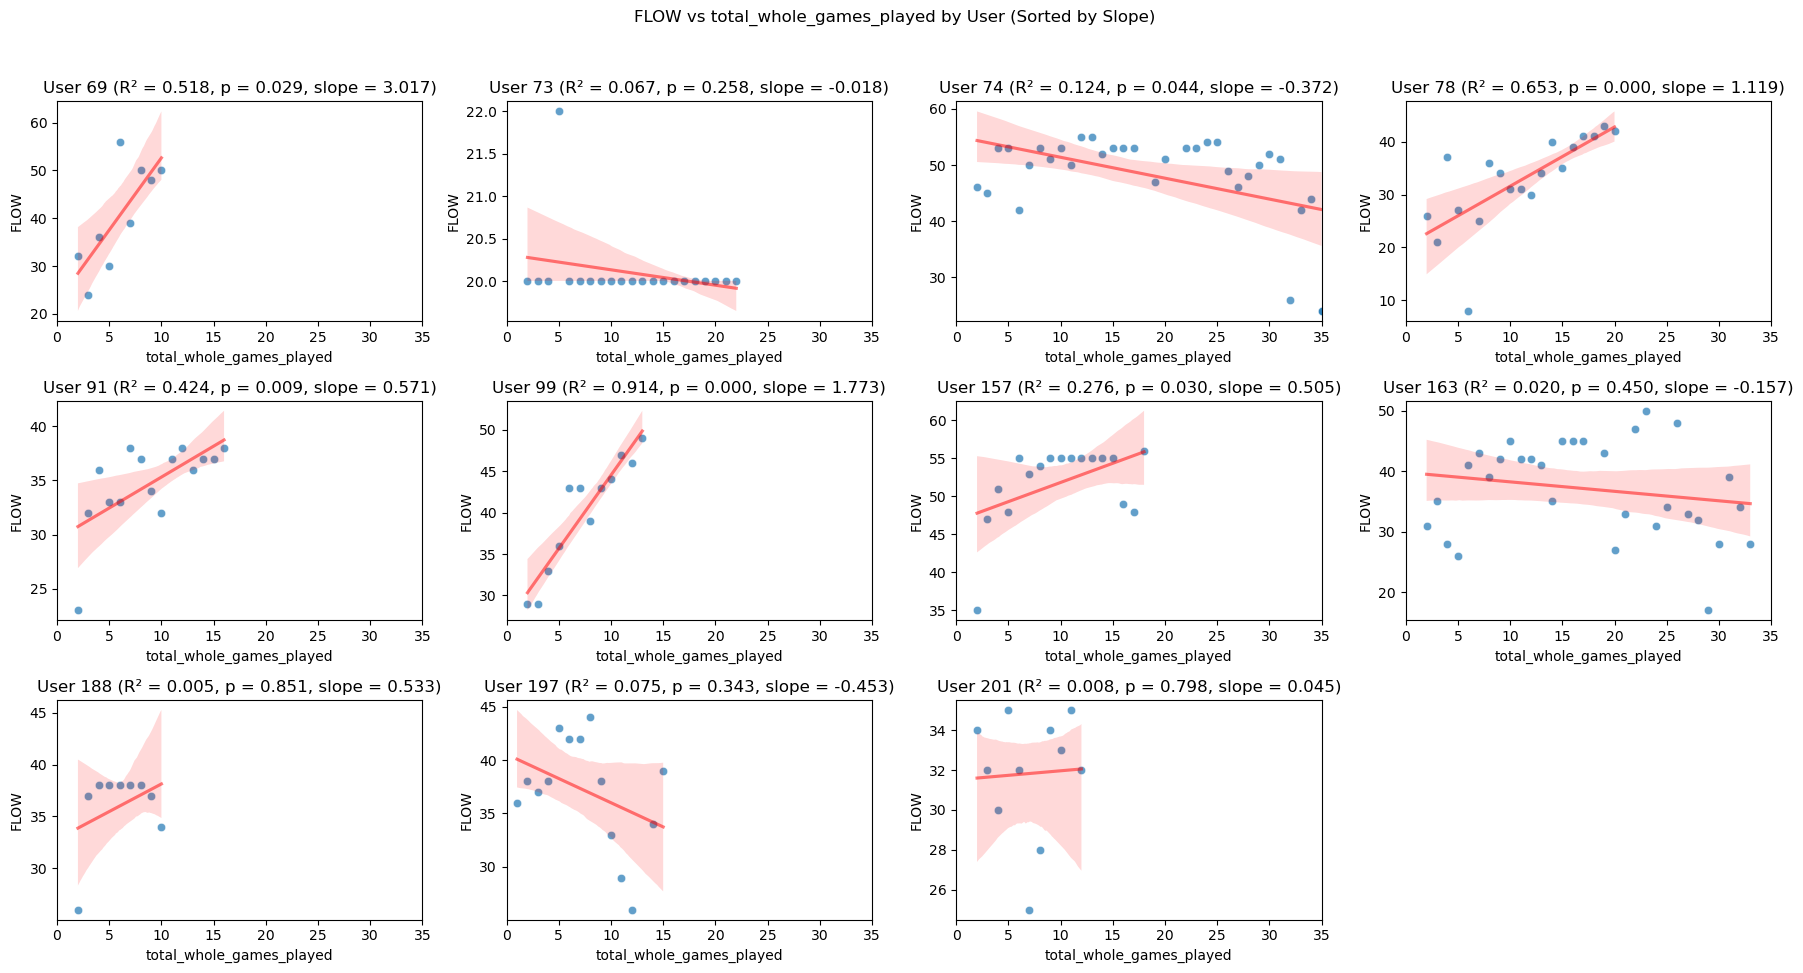

In [23]:
from scipy import stats
import numpy as np

# Calculate number of subplots needed
n_users = len(perf_psych_df["user_id"].unique())
m = int(np.ceil(np.sqrt(n_users)))

# Variable names (columns)
x = "total_whole_games_played"
y = "FLOW"

# Calculate slopes for each user and sort
user_slopes = []
for user_id in perf_psych_df["user_id"].unique():
    user_data = perf_psych_df[perf_psych_df["user_id"] == user_id]
    if len(user_data) > 1:  # Only calculate slope if user has multiple data points
        slope, _, _, _, _ = stats.linregress(user_data[x], user_data[y])
        user_slopes.append((user_id, slope))
    else:
        user_slopes.append((user_id, 0))

## Sort users by slope
# sorted_users = [user_id for user_id, _ in sorted(user_slopes, key=lambda x: x[1])]
sorted_users = perf_psych_df["user_id"].unique()

# Create subplots
fig, axes = plt.subplots(m, m, figsize=(18, 12))
fig.suptitle(f"{y} vs {x} by User (Sorted by Slope)", y=1.02)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot for each user
for i, user_id in enumerate(sorted_users):
    user_data = perf_psych_df[perf_psych_df["user_id"] == user_id]

    # Calculate Spearman correlation and R^2
    corr, p_value = stats.spearmanr(user_data[x], user_data[y])
    r_squared = corr**2

    axes[i].set_xlim(0, perf_psych_df[x].max())

    scatter = sns.scatterplot(data=user_data, x=x, y=y, ax=axes[i], alpha=0.7)

    sns.regplot(
        data=user_data,
        x=x,
        y=y,
        ax=axes[i],
        scatter=False,
        color="red",
        line_kws={"alpha": 0.5},
    )

    # Add R^2 value and slope to plot title
    slope = next(slope for uid, slope in user_slopes if uid == user_id)
    axes[i].set_title(
        f"User {user_id} (R² = {r_squared:.3f}, p = {p_value:.3f}, slope = {slope:.3f})"
    )
    axes[i].set_xlabel(f"{x}")
    axes[i].set_ylabel(f"{y}")

# Hide empty subplots
for i in range(n_users, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

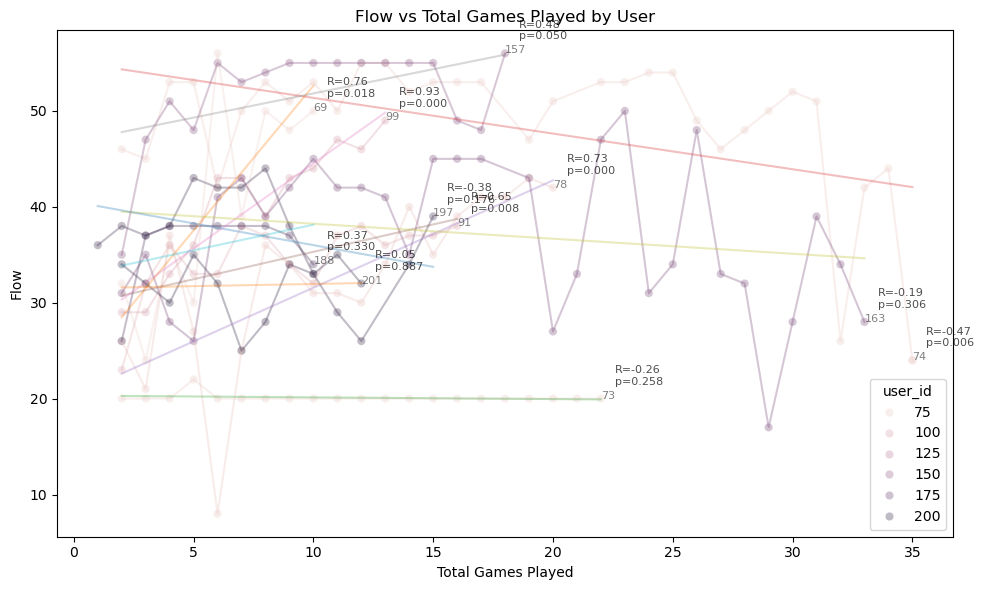

In [13]:
## Same as above but plotted in the same space
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy import stats

# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=perf_psych_df,
#                 x='total_whole_games_played',
#                 y='FLOW',
#                 hue='user_id',
#                 alpha=0.3)


# sns.lineplot(data=perf_psych_df,
#              x='total_whole_games_played',
#              y='FLOW',
#              hue='user_id',
#              alpha=0.3,
#              legend=False)

# # Add user_id labels and regression lines for each user
# for user_id in perf_psych_df['user_id'].unique():
#     user_data = perf_psych_df[perf_psych_df['user_id'] == user_id]
#     last_row = user_data.iloc[-1]  # Get the last row for each user

#     # Add user_id label
#     plt.annotate(str(int(user_id)),
#                 (last_row['total_whole_games_played'], last_row['FLOW']),
#                 fontsize=8,
#                 alpha=0.5)

#     # Calculate regression line
#     if len(user_data) > 1:  # Only plot regression if user has multiple data points
#         slope, intercept, r_value, p_value, _ = stats.linregress(user_data['total_whole_games_played'], user_data['FLOW'])

#         # Plot regression line
#         x_values = user_data['total_whole_games_played']
#         y_values = slope * x_values + intercept
#         plt.plot(x_values, y_values, alpha=0.3)

#         # Add R and p-value annotation
#         plt.annotate(f'R={r_value:.2f}\np={p_value:.3f}',
#                     (last_row['total_whole_games_played'], last_row['FLOW']),
#                     xytext=(10, 10),
#                     textcoords='offset points',
#                     fontsize=8,
#                     alpha=0.7)

# plt.title('Flow vs Total Games Played by User')
# plt.xlabel('Total Games Played')
# plt.ylabel('Flow')
# plt.tight_layout()
# plt.show()


In [19]:
from scipy import stats

# Calculate correlation and p-value
corr, p_value = stats.pearsonr(perf_psych_df["score"], perf_psych_df["FLOW"])

# Print results
print(f"Pearson correlation coefficient: {corr:.3f}")
print(f"P-value: {p_value}")
print(f"R-squared: {corr**2:.3f}")

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    perf_psych_df["FLOW"], perf_psych_df["score"]
)
print(f"\nLinear regression results:")
print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err:.3f}")

Pearson correlation coefficient: 0.402
P-value: 8.343496502308618e-09
R-squared: 0.161

Linear regression results:
Slope: 106.308
Intercept: 934.971
R-squared: 0.161
P-value: 8.343496502308236e-09
Standard error: 17.623


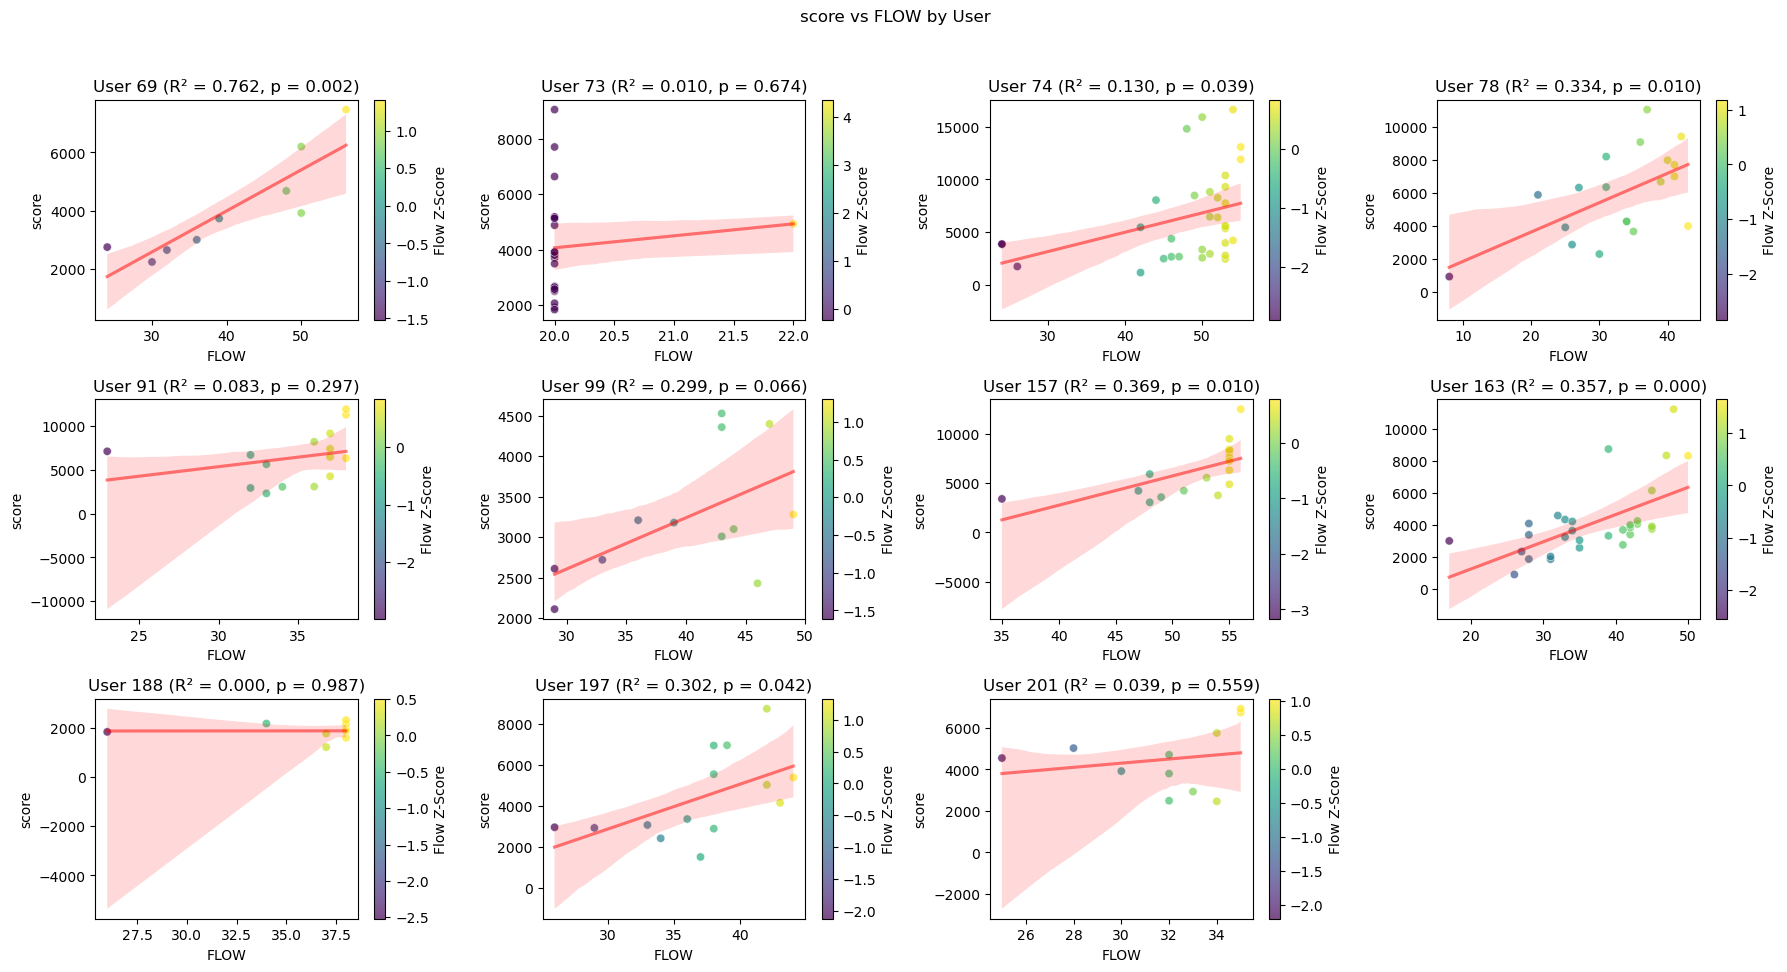

In [15]:
from scipy import stats

# Calculate number of subplots needed
n_users = len(perf_psych_df["user_id"].unique())
m = int(np.ceil(np.sqrt(n_users)))

# Variable names (columns)
x = "FLOW"
y = "score"

# Create subplots
fig, axes = plt.subplots(m, m, figsize=(18, 12))
fig.suptitle(f"{y} vs {x} by User", y=1.02)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot for each user
for i, user_id in enumerate(perf_psych_df["user_id"].unique()):
    user_data = perf_psych_df[perf_psych_df["user_id"] == user_id]

    # Calculate Spearman correlation and R^2
    corr, p_value = stats.pearsonr(user_data[x], user_data[y])
    r_squared = corr**2

    scatter = sns.scatterplot(
        data=user_data,
        x=x,
        y=y,
        c=user_data["flow_z_score"],
        cmap="viridis",
        ax=axes[i],
        alpha=0.7,
    )

    # Add colorbar for each subplot
    plt.colorbar(scatter.collections[0], ax=axes[i], label="Flow Z-Score")

    sns.regplot(
        data=user_data,
        x=x,
        y=y,
        ax=axes[i],
        scatter=False,
        color="red",
        line_kws={"alpha": 0.5},
    )

    # Add R^2 value and slope to plot title
    axes[i].set_title(f"User {user_id} (R² = {r_squared:.3f}, p = {p_value:.3f})")
    axes[i].set_xlabel(f"{x}")
    axes[i].set_ylabel(f"{y}")

# Hide empty subplots
for i in range(n_users, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

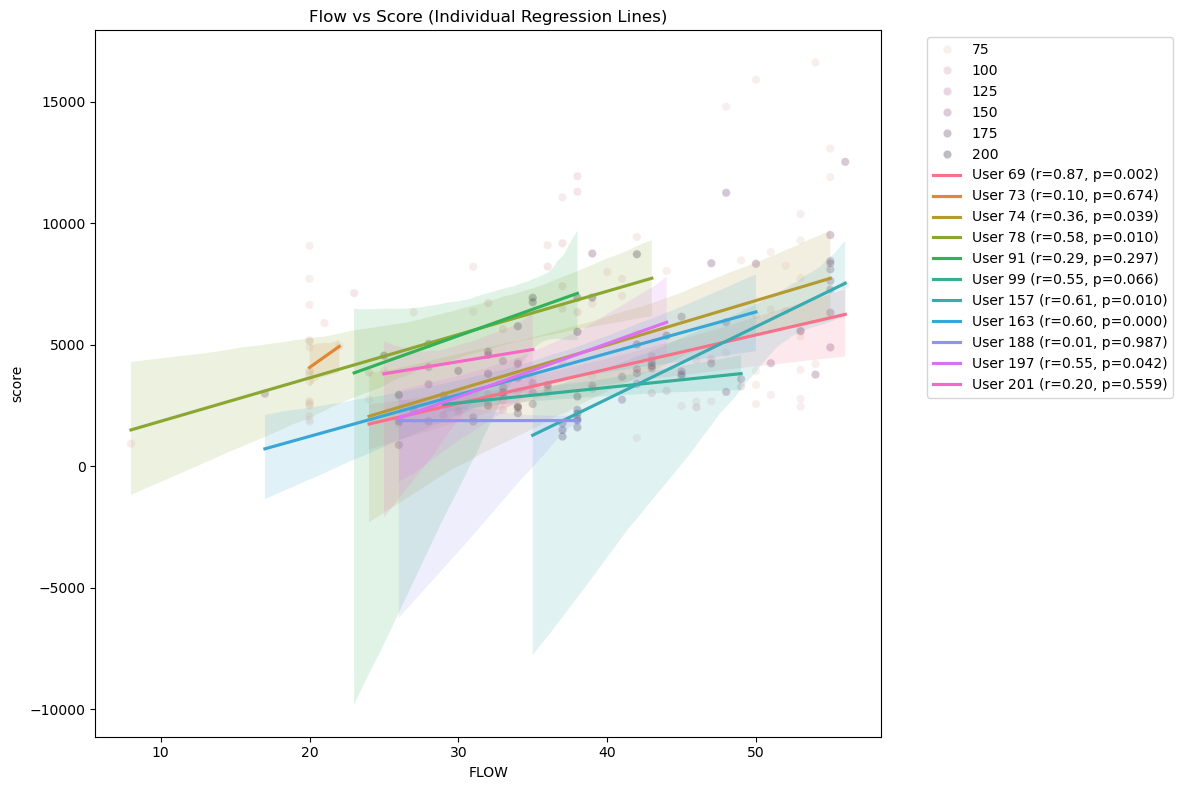

In [16]:
# Create a figure with a larger size to accommodate multiple regression lines
plt.figure(figsize=(12, 8))

# Get unique user_ids
unique_users = perf_psych_df["user_id"].unique()

# Create a color palette for different users
colors = sns.color_palette("husl", n_colors=len(unique_users))

# Plot scatter points for each user
sns.scatterplot(data=perf_psych_df, x="FLOW", y="score", hue="user_id", alpha=0.3)

# Plot regression lines for each user and calculate statistics
for i, user_id in enumerate(unique_users):
    user_data = perf_psych_df[perf_psych_df["user_id"] == user_id]
    if len(user_data) > 1:  # Only plot regression if user has multiple data points
        # Calculate correlation and p-value
        corr, p_value = stats.pearsonr(user_data["FLOW"], user_data["score"])

        # Plot regression line
        sns.regplot(
            data=user_data,
            x="FLOW",
            y="score",
            scatter=False,
            color=colors[i],
            ci=95,
            label=f"User {user_id} (r={corr:.2f}, p={p_value:.3f})",
        )

plt.title("Flow vs Score (Individual Regression Lines)")
plt.xlabel("FLOW")
plt.ylabel("score")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM

# Assuming we have perf_psych_df from the previous code
# We'll create a mixed linear model with:
# - Fixed effect: total_games_played (to capture learning/experience)
# - Random effect: user_id (to account for individual differences)
# - Dependent variable: score
# - Additional fixed effect: FLOW (to see its relationship with performance)

# First ensure user_id is treated as categorical
perf_psych_df["user_id"] = perf_psych_df["user_id"].astype("category")

# Fit the mixed linear model
model = MixedLM(
    endog=perf_psych_df["score"],
    exog=sm.add_constant(perf_psych_df["total_whole_games_played"]),
    groups=perf_psych_df["user_id"],
)

result = model.fit()

# Print the results
print(result.summary())
result.params

                   Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      score       
No. Observations:        191          Method:                  REML        
No. Groups:              11           Scale:                   6298267.6094
Min. group size:         9            Log-Likelihood:          -1762.0527  
Max. group size:         33           Converged:               Yes         
Mean group size:         17.4                                              
---------------------------------------------------------------------------
                            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
---------------------------------------------------------------------------
const                       3402.419  475.836 7.150 0.000 2469.797 4335.041
total_whole_games_played     126.643   25.504 4.966 0.000   76.656  176.629
Group Var                1265490.204  307.666                              



const                       3402.418998
total_whole_games_played     126.642687
Group Var                      0.200927
dtype: float64

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM

# Assuming we have perf_psych_df from the previous code
# We'll create a mixed linear model with:
# - Fixed effect: total_games_played (to capture learning/experience)
# - Random effect: user_id (to account for individual differences)
# - Dependent variable: score
# - Additional fixed effect: FLOW (to see its relationship with performance)

# First ensure user_id is treated as categorical
perf_psych_df["user_id"] = perf_psych_df["user_id"].astype("category")

# Fit the mixed linear model
model = MixedLM(
    endog=perf_psych_df["score"],
    exog=sm.add_constant(perf_psych_df[["FLOW"]]),
    groups=perf_psych_df["user_id"],
)

result = model.fit()

# Print the results
print(result.summary())
result

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  score       
No. Observations:   191      Method:              REML        
No. Groups:         11       Scale:               5763077.1507
Min. group size:    9        Log-Likelihood:      -1755.9367  
Max. group size:    33       Converged:           Yes         
Mean group size:    17.4                                      
--------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------
const        -963.105 1068.584 -0.901 0.367 -3057.491 1131.280
FLOW          152.383   25.538  5.967 0.000   102.329  202.438
Group Var 2043051.612  501.238                                

